In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import numpy as np
import pickle
import os
import sys
sys.path.insert(0, "/recsys_data/RecSys/fashion/automl/efficientnetv2")
import effnetv2_model
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
embed_dir = "/recsys_data/RecSys/fashion/polyvore-dataset/precomputed"
image_embedding_file = os.path.join(embed_dir, "effnet_tuned_polyvore.pkl")

with open(image_embedding_file, "rb") as fr:
    image_embedding_dict = pickle.load(fr)
print(f"Loaded {len(image_embedding_dict)} image embeddings")

Loaded 261057 image embeddings


In [4]:
eff2_model = tf.keras.models.Sequential(
                [
                    tf.keras.layers.InputLayer(input_shape=[224, 224, 3]),
                    effnetv2_model.get_model("efficientnetv2-b0", include_top=False),
                ]
            )

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


In [91]:
class HashTable:
    def __init__(self, hash_size, inp_dimensions):
        self.hash_table = dict()
        self.hash_size = hash_size
        self.inp_dimensions = inp_dimensions
        self.projections = np.random.randn(self.hash_size, inp_dimensions)
        
    def generate_hash(self, inp_vector):
        bools = (np.dot(inp_vector, self.projections.T) > 0).astype('int')
        return ''.join(bools.astype('str'))

    def add(self, inp_vec, label):
        entry = {'label': label}
        hash_value = self.generate_hash(inp_vec)
#         for h in hash_value:
#             if h in self.hash_table:
#                 self.hash_table[h].append(entry)
#             else:
#                 self.hash_table[h] = [entry]

        self.hash_table[hash_value] = self.hash_table\
            .get(hash_value, list()) + [label]
        
    def query(self, inp_vec):
        hash_value = self.generate_hash(inp_vec)
        return self.hash_table.get(hash_value, [])
        

class LSH:
    def __init__(self, num_tables, hash_size, inp_dimensions):
        self.num_tables = num_tables
        self.hash_size = hash_size
        self.inp_dimensions = inp_dimensions
        self.hash_tables = list()
        for i in range(self.num_tables):
            self.hash_tables.append(HashTable(self.hash_size, self.inp_dimensions))
    
    def add(self, inp_vec, label):
        for table in self.hash_tables:
            table.add(inp_vec, label)
    
    def query(self, inp_vec):
        results = list()
        for table in self.hash_tables:
            results.extend(table.query(inp_vec))
        return list(set(results))
    
class ImageSearch:
    
    def __init__(self, image_dict, num_tables, hash_size, max_num):
        self.inp_dim = 1280
        self.max_num = max_num
        self.lsh = LSH(num_tables, hash_size, self.inp_dim)
        self.image_dict = image_dict
        self.num_features_in_file = dict()
        for f in self.image_dict:
            self.num_features_in_file[f] = 0
                
    def train(self):
        count = 0
        for item in tqdm(self.image_dict):
            features = self.image_dict[item]
            self.lsh.add(features, item)
            self.num_features_in_file[item] += len(features)
            count += 1
            if self.max_num and count > self.max_num:
                break
                
    def query(self, image):
        image = tf.keras.preprocessing.image.load_img(image)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        image_arr = tf.image.resize_with_pad(image_arr, target_height=224, target_width=224).numpy()
        image_arr /= 255.0
        image_embed = tf.squeeze(eff2_model(tf.expand_dims(image_arr, 0)))
        results = self.lsh.query(image_embed)
        print('num results', len(results))

        counts = dict()
        for r in results:
            if r in counts:
                counts[r] += 1
            else:
                counts[r] = 1
        for k in counts:
            counts[k] = float(counts[k])/self.num_features_in_file[k]
        return counts


In [82]:
def plot_similar_items(items, image_dir):
    nrows, ncols = 1, len(items)
    figure, axis = plt.subplots(nrows, ncols, figsize=(20,5))
    for ii in range(ncols):
        item = items[ii]
        img = plt.imread(os.path.join(image_dir, item+".jpg"))
        imgplot = axis[ii].imshow(img)
        axis[ii].axis('off')
    plt.show()


In [96]:
num_tables, hash_size = 10, 20
img_search = ImageSearch(image_embedding_dict, num_tables, hash_size, max_num=None)
img_search.train()

100%|██████████| 261057/261057 [03:31<00:00, 1236.10it/s]


<Figure size 2000x500 with 0 Axes>

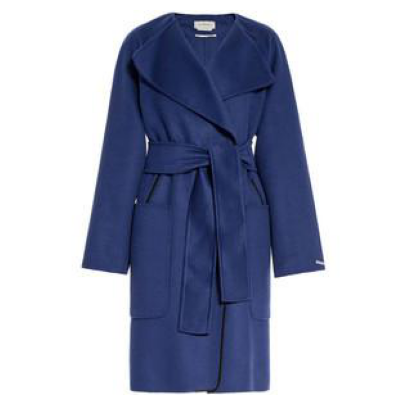

num results 2


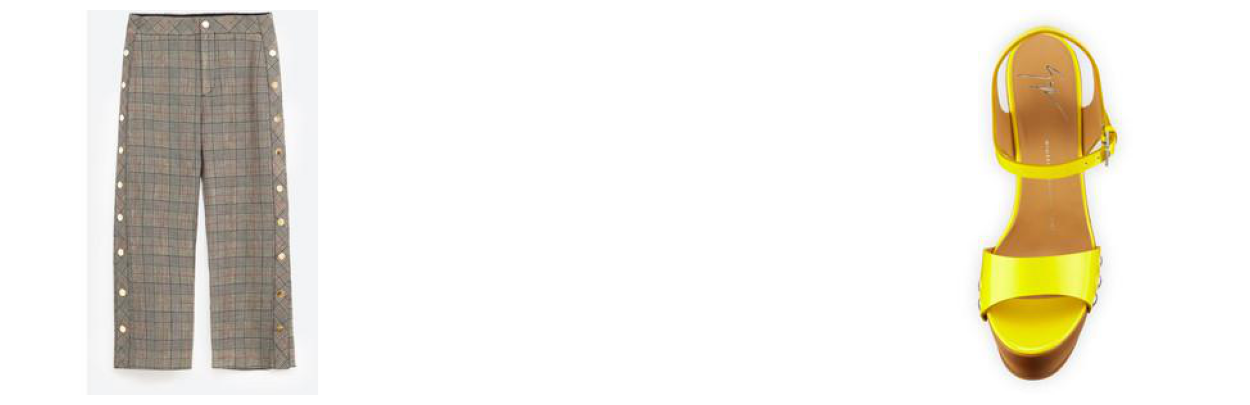

In [97]:
base_dir = "/recsys_data/RecSys/fashion/polyvore-dataset/polyvore_outfits"
image_dir = os.path.join(base_dir, "images")

item = "200162527.jpg"
figure, axis = plt.subplots(1, 1, figsize=(10,5))
img = plt.imread(os.path.join(image_dir, item))
imgplot = axis.imshow(img)
axis.axis('off')
plt.show()

results = img_search.query(os.path.join(image_dir, item))
sorted_items = []
for r in sorted(results, key=results.get, reverse=True):
    sorted_items.append(r)
#     print(r, results[r])
plot_similar_items(sorted_items[:5], image_dir)

In [108]:
import heapq

def get_similar_products(query):
#     query = os.path.join(image_dir, query)
    image = tf.keras.preprocessing.image.load_img(query)
    image_arr = tf.keras.preprocessing.image.img_to_array(image)
    # image_arr = tf.image.resize(image_arr, (224, 224)).numpy()
    image_arr = tf.image.resize_with_pad(image_arr, target_height=224, target_width=224).numpy()
    image_arr /= 255.0

    image_embed = tf.squeeze(eff2_model(tf.expand_dims(image_arr, 0)))
    q_vec = image_embed #.numpy()
    image_dist = []
    count = 0
    for image, i_vec in tqdm(image_embedding_dict.items()):
        dist = np.linalg.norm(q_vec - i_vec.numpy())
        heapq.heappush(image_dist, (dist, image))  # minheap
        count += 1

    top_images = [heapq.heappop(image_dist) for _ in range(5)]
    top_images = [item for s, item in top_images]
    return top_images


100%|██████████| 261057/261057 [01:48<00:00, 2408.74it/s]


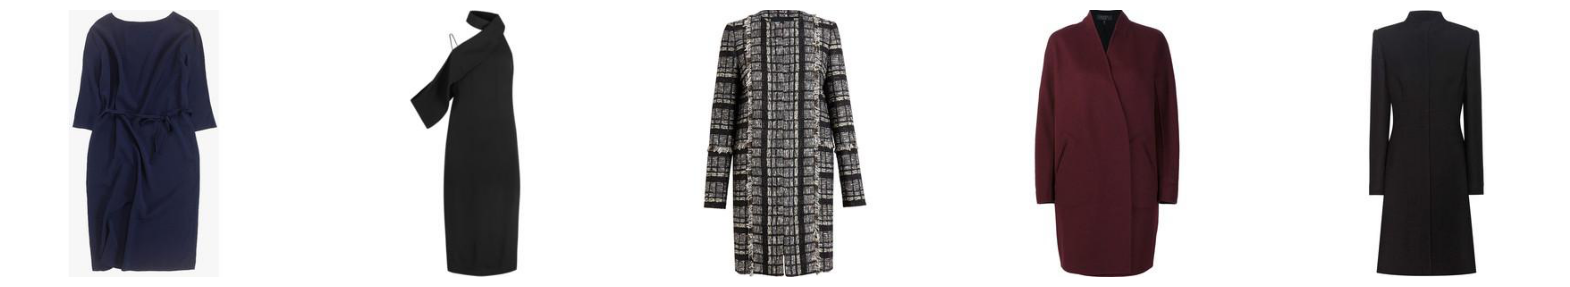

In [111]:
results = get_similar_products(os.path.join(image_dir, item))
plot_similar_items(results, image_dir)

In [11]:
hash_table = HashTable(hash_size=10, inp_dimensions=1280)

In [12]:
list(image_embedding_dict.keys())[:10]

['114082981',
 '200162527',
 '129089366',
 '206910887',
 '191335829',
 '181327897',
 '190129940',
 '114190222',
 '128377889',
 '212676450']

In [13]:
hash_table.generate_hash(image_embedding_dict['114082981'])

'1000100110'